In [1]:
import sys
sys.path += ['..']

In [2]:
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from financial_ml.features.systematic_default import FirmStructuralCreditRisk

In [56]:
fmp_api_key = ''
api_base = 'https://financialmodelingprep.com/api'

In [57]:
def read_treasury_yields(file_path):
    treasury_yields = pd.read_csv(file_path)
    treasury_yields = treasury_yields.rename(columns={'DATE': 'date', 'DGS1': 'yield'})
    treasury_yields['date'] = pd.to_datetime(treasury_yields['date'])
    treasury_yields = treasury_yields.dropna(subset='yield')
    treasury_yields = treasury_yields[treasury_yields['yield'] != '.']
    treasury_yields['yield'] = treasury_yields['yield'].astype(float)/100
    return treasury_yields

In [58]:
def read_bonds_index_data(file_path):
    bnd_idx = pd.read_excel(file_path).dropna()
    bnd_idx = bnd_idx.iloc[2:]
    bnd_idx.columns = ['date', 'price']
    bnd_idx['date'] = pd.to_datetime(bnd_idx['date'])
    bnd_idx['price'] = bnd_idx['price'].astype(float)
    return bnd_idx

In [59]:
def get_equities_index_data():
    spy_yf = yf.Ticker('SPY')
    spy_df = spy_yf.history(interval='1d', period='11y', prepost=False)
    res = pd.DataFrame({'date': pd.to_datetime(spy_df.index.date), 'price': spy_df['Close']})
    res = res.reset_index(drop=True)
    return res

In [60]:
def get_firm_data(ticker):
    market_cap_api = f'{api_base}/v3/historical-market-capitalization/{ticker}?limit=7700&apikey={fmp_api_key}'
    market_caps = requests.get(market_cap_api).json()
    market_caps = pd.DataFrame(market_caps)
    market_caps = market_caps[['date', 'marketCap']]
    market_caps['date'] = pd.to_datetime(market_caps['date'])
    market_caps = market_caps.sort_values('date').reset_index(drop=True)
    
    balance_sheet_api = f'{api_base}/v3/balance-sheet-statement/{ticker}?period=quarter&limit=120&apikey={fmp_api_key}'
    balance_sheets = requests.get(balance_sheet_api).json()
    balance_sheets_df = pd.DataFrame(balance_sheets)
    balance_sheets_df = balance_sheets_df[['acceptedDate', 'shortTermDebt', 'longTermDebt']]
    balance_sheets_df['acceptedDate'] = pd.to_datetime(balance_sheets_df['acceptedDate'])
    balance_sheets_df = balance_sheets_df.sort_values('acceptedDate')

    join_indices = market_caps['date'].apply(lambda d: balance_sheets_df['acceptedDate'].searchsorted(d) - 1).values
    balance_sheets_join = balance_sheets_df.iloc[join_indices].copy()
    balance_sheets_join['acceptedDate'] = balance_sheets_join['acceptedDate'].where(join_indices >= 0)
    balance_sheets_join = balance_sheets_join.reset_index(drop=True)

    firm_data = pd.concat([market_caps, balance_sheets_join], axis=1)
    firm_data = firm_data.dropna(subset='acceptedDate')
    firm_data = firm_data.rename(columns={'acceptedDate': 'balanceSheetDate'})
    return firm_data

In [61]:
def create_systematic_default_dataset(firm_data, treasury_yields, bonds_index, equities_index):
    dataset = firm_data.merge(treasury_yields, on='date')
    dataset = dataset.rename(columns={'yield': 'treasury_yield'})
    dataset = dataset.merge(bonds_index, on='date').rename(columns={'price': 'bonds_index'})
    dataset = dataset.merge(equities_index, on='date').rename(columns={'price': 'equities_index'})
    dataset = dataset.dropna(subset='treasury_yield')
    return dataset

In [71]:
def create_firm_model(dataset, interval, expected_market_ret, equity_ratio=0.81, return_assets=False):
    equity_mkt_rets = np.diff(np.log(dataset['equities_index']))
    bnd_mkt_rets = np.diff(np.log(dataset['bonds_index']))
    market_rets = equity_ratio * equity_mkt_rets + (1 - equity_ratio) * bnd_mkt_rets
    
    debt_values = (dataset['shortTermDebt'] + dataset['longTermDebt']/2).values
    risk_free_rates = dataset['treasury_yield'].iloc[:-1].values
    
    model = FirmStructuralCreditRisk()
    res = model.fit(
        expected_market_ret=expected_market_ret,
        market_rets=market_rets,
        equity_values=dataset['marketCap'].values,
        debt_values=debt_values,
        debt_maturities=[1] * len(dataset),
        interval=interval,
        risk_free_rates=risk_free_rates,
    )
    if return_assets:
        return model, res
    else:
        return model

In [9]:
# Data from https://fred.stlouisfed.org/series/DGS1
treasury_yields = read_treasury_yields('../data/systematic_default/treasury_yield_1Y.csv')

# Data from https://www.spglobal.com/spdji/en/indices/fixed-income/sp-500-bond-index/#overview
bonds_index = read_bonds_index_data('../data/systematic_default/sp500_bnd_idx.xls')

equities_index = get_equities_index_data()

## Single Firm Default

In [19]:
ticker = 'AAPL'
firm_data = get_firm_data(ticker)

In [62]:
dataset = create_systematic_default_dataset(
    firm_data=firm_data,
    treasury_yields=treasury_yields,
    bonds_index=bonds_index,
    equities_index=equities_index
)
dataset.to_csv(f'../data/{ticker.lower()}_structural_data.csv', index=False)

In [19]:
dataset = pd.read_csv(f'../data/{ticker.lower()}_structural_data.csv')
dataset['date'] = pd.to_datetime(dataset['date'])

In [63]:
dataset

,date,marketCap,balanceSheetDate,shortTermDebt,longTermDebt,treasury_yield,bonds_index,equities_index
0,2013-05-31,413135584848,2013-04-23 21:29:23,0,0,0.0014,368.08,135.333801
1,2013-06-03,414038402618,2013-04-23 21:29:23,0,0,0.0014,368.35,136.079025
2,2013-06-04,412744621027,2013-04-23 21:29:23,0,0,0.0014,367.69,135.424850
3,2013-06-05,408886425427,2013-04-23 21:29:23,0,0,0.0014,367.42,133.528839
4,2013-06-06,402777615727,2013-04-23 21:29:23,0,0,0.0014,367.75,134.737656
...,...,...,...,...,...,...,...,...
2510,2023-06-16,2919360517680,2023-05-04 18:03:52,12574000000,97041000000,0.0524,470.06,439.459991
2511,2023-06-20,2920781361540,2023-05-04 18:03:52,12574000000,97041000000,0.0524,471.45,437.179993
2512,2023-06-21,2904204849840,2023-05-04 18:03:52,12574000000,97041000000,0.0525,471.74,434.940002
2513,2023-06-22,2952197798000,2023-05-04 18:03:52,12574000000,97041000000,0.0529,469.57,436.510010


In [72]:
dataset_monthly = dataset.resample('MS', on='date').first()
dataset_monthly

,marketCap,balanceSheetDate,shortTermDebt,longTermDebt,treasury_yield,bonds_index,equities_index
date,,,,,,,
2013-05-01,413135584848,2013-04-23 21:29:23,0,0,0.0014,368.08,135.333801
2013-06-01,414038402618,2013-04-23 21:29:23,0,0,0.0014,368.35,136.079025
2013-07-01,378663951820,2013-04-23 21:29:23,0,0,0.0015,359.17,134.310242
2013-08-01,422577570153,2013-07-24 17:02:02,0,16958000000,0.0013,359.46,142.051270
2013-09-01,452098590112,2013-07-24 17:02:02,0,16958000000,0.0014,357.83,136.832321
...,...,...,...,...,...,...,...
2023-02-01,2295925806220,2022-10-27 18:01:14,21110000000,98959000000,0.0466,477.31,407.723602
2023-03-01,2294031347740,2023-02-02 18:01:30,11483000000,99627000000,0.0506,457.82,391.783875
2023-04-01,2623351380180,2023-02-02 18:01:30,11483000000,99627000000,0.0460,474.30,409.429138


In [75]:
firm_model, (asset_rets, asset_values) = create_firm_model(
    dataset_monthly,
    interval=1/12,
    expected_market_ret=0.12,
    return_assets=True
)

<Axes: ylabel='marketCap'>

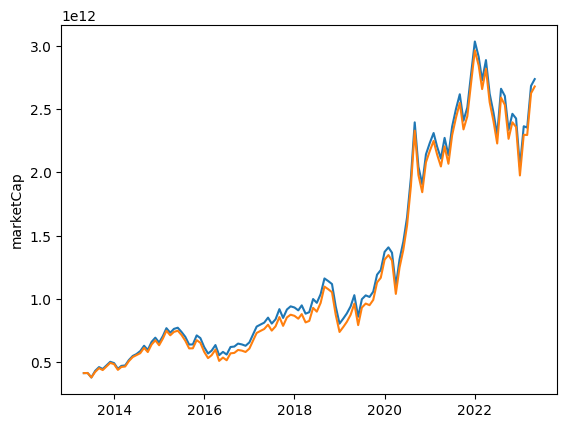

In [84]:
sns.lineplot(x=dataset_monthly.index.values[:-1], y=asset_values)
sns.lineplot(x=dataset_monthly.index.values[:-1], y=dataset_monthly['marketCap'].iloc[:-1])

In [89]:
equity_mkt_rets = np.diff(np.log(dataset_monthly['equities_index']))
bnd_mkt_rets = np.diff(np.log(dataset_monthly['bonds_index']))
equity_ratio = 0.81
market_rets = equity_ratio * equity_mkt_rets + (1 - equity_ratio) * bnd_mkt_rets
risk_free_rates = dataset_monthly['treasury_yield'].iloc[:-1]

equity_mk_ex_rets = equity_mkt_rets - risk_free_rates/12
mkt_ex_rets = market_rets - risk_free_rates*1/12

equity_ex_rets = np.diff(np.log(dataset_monthly['marketCap'].values)) - risk_free_rates*1/12
asset_ex_rets = asset_rets - risk_free_rates*1/12

<Axes: xlabel='treasury_yield', ylabel='treasury_yield'>

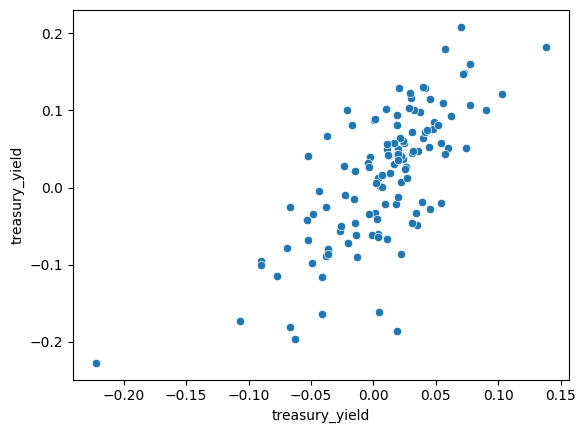

In [90]:
sns.scatterplot(x=equity_mk_ex_rets, y=equity_ex_rets)

<Axes: xlabel='treasury_yield', ylabel='treasury_yield'>

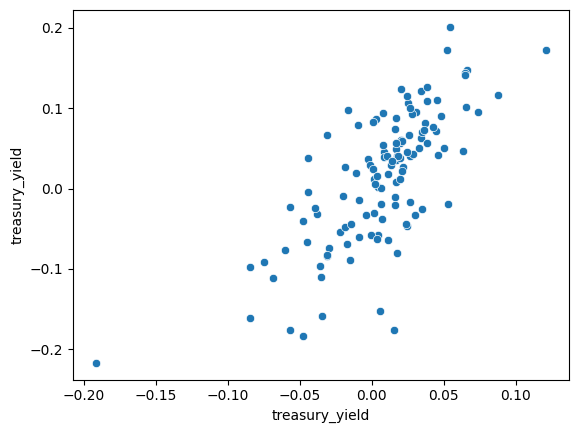

In [91]:
sns.scatterplot(x=mkt_ex_rets, y=asset_ex_rets)

In [92]:
firm_model.firm_params

FirmParams(alpha=0.062303769121042754, beta=1.5043512910470846, sigma=0.19422260605745353)

In [95]:
firm_model.predict_default(
    equity_value=dataset_monthly['marketCap'].iloc[-1],
    debt_value=(dataset_monthly['shortTermDebt'].iloc[-1] + dataset_monthly['longTermDebt'].iloc[-1]/2),
    debt_maturity=1,
    risk_free_rate=risk_free_rates[-1],
    market_ret=-0.5
)

0.0

## Systematic Default

In [11]:
tickers = ['COST', 'CSCO', 'CRM', 'ACN', 'ADBE', 'LIN', 'TXN', 'DHR']
datasets = {}

for ticker in tickers:
    firm_data = get_firm_data(ticker)
    dataset = create_systematic_default_dataset(
        firm_data=firm_data,
        treasury_yields=treasury_yields,
        bonds_index=bonds_index,
        equities_index=equities_index
    )
    dataset.to_csv(f'../data/systematic_default/{ticker.lower()}_data.csv', index=False)
    datasets[ticker] = dataset
    print(f'Ticker: {ticker}. # Rows: {len(dataset)}. From: {dataset.date.iloc[0]}. To: {dataset.date.iloc[-1]}')

Ticker: COST. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: CSCO. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: CRM. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: ACN. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: ADBE. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: LIN. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: TXN. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00
Ticker: DHR. # Rows: 2515. From: 2013-05-31 00:00:00. To: 2023-06-23 00:00:00


In [15]:
datasets_monthly = {
    ticker: dataset.resample('MS', on='date').first()
    for ticker, dataset in datasets.items()
}

In [74]:
firms_data = {
    ticker: {
        'equity_value': dataset['marketCap'].iloc[-1],
        'debt_value': (dataset['shortTermDebt'].iloc[-1] + dataset['longTermDebt'].iloc[-1]/2),
        'debt_maturity': 1,
        'risk_free_rate': dataset['treasury_yield'].iloc[-1],
    }
    for ticker, dataset in datasets.items()
}

In [86]:
def get_default_count_probs(default_vectors):
    default_vectors = [v[:, np.newaxis] for v in default_vectors]

    while len(default_vectors) > 1:
        next_vectors = []
        for i in range(0, len(default_vectors) - 1, 2):
            default_mat = default_vectors[i] @ default_vectors[i + 1].T
            max_num_defaults = default_mat.shape[0] + default_mat.shape[1] - 2
            default_vec = np.zeros(max_num_defaults + 1)
    
            for j in range(default_mat.shape[0]):
                for k in range(default_mat.shape[1]):
                    default_vec[j + k] += default_mat[j, k]

            default_vec = default_vec[:, np.newaxis]
            next_vectors.append(default_vec)

        if len(default_vectors) % 2 != 0:
            next_vectors.append(default_vectors[-1])
        default_vectors = next_vectors

    return default_vectors[0].squeeze()


def get_systematic_default_probs(datasets, interval, firms_data, market_ret):
    firm_models = {
        ticker: create_firm_model(
            dataset,
            interval=interval,
            expected_market_ret=market_ret,
        )
        for ticker, dataset in datasets.items()
    }

    default_probs = {
        ticker: model.predict_default(
            equity_value=firms_data[ticker]['equity_value'],
            debt_value=firms_data[ticker]['debt_value'],
            debt_maturity=firms_data[ticker]['debt_maturity'],
            risk_free_rate=firms_data[ticker]['risk_free_rate'],
            market_ret=market_ret
        )
        for ticker, model in firm_models.items()
    }
    default_vectors = [np.array([1 - p, p]) for p in default_probs.values()]
    sys_default_probs = get_default_count_probs(default_vectors)
    return sys_default_probs, default_probs, firm_models

In [87]:
sys_probs, firm_probs, firm_models = get_systematic_default_probs(datasets_monthly, 1/12, firms_data, 0.12)

In [88]:
sys_probs

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [89]:
firm_probs

{'COST': 0.0,
 'CSCO': 0.0,
 'CRM': 0.0,
 'ACN': 0.0,
 'ADBE': 0.0,
 'LIN': 0.0,
 'TXN': 0.0,
 'DHR': 0.0}

In [93]:
[(ticker, m.firm_params) for ticker, m in firm_models.items()]

[('COST',
  FirmParams(alpha=0.07925201002585935, beta=0.8161477340258506, sigma=0.15047370044593636)),
 ('CSCO',
  FirmParams(alpha=-0.04396181780546432, beta=1.0293401866473983, sigma=0.17538263265630702)),
 ('CRM',
  FirmParams(alpha=0.09603773060665813, beta=1.4326354098233434, sigma=0.2211556147146015)),
 ('ACN',
  FirmParams(alpha=0.010332314595499189, beta=1.3372844140938511, sigma=0.1189978621590919)),
 ('ADBE',
  FirmParams(alpha=0.1026609234587237, beta=1.4189721704923561, sigma=0.19773058519500633)),
 ('LIN',
  FirmParams(alpha=0.08785166087690738, beta=0.8098650761613346, sigma=0.20064037310970392)),
 ('TXN',
  FirmParams(alpha=0.025331478124824718, beta=1.2431560628213045, sigma=0.13755529235904568)),
 ('DHR',
  FirmParams(alpha=0.047063369085413, beta=0.962156509272216, sigma=0.15861115894450772))]